In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import csv
from io import StringIO
from imblearn.under_sampling import RandomUnderSampler
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
import nltk
import sys
from scipy.stats import t
from scipy import stats
import statsmodels.api as sa
import statsmodels.formula.api as sfa
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.svm import SVC
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. Exploratory Data Analysis

In [2]:
logins = pd.read_json('logins.json',orient = 'columns')


In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


__Note:__ The login_time shows 1970 as the year but it might be an error. If the original column was in unix time then sometimes, when the data is converted the data becomes 1970s.

In [4]:
logins['dt'] = pd.to_datetime(logins['login_time'],unit = 's')

In [5]:
#onvert data to every 15 minutes
logins['dt_fif'] = logins['dt'].dt.round('15min')

In [6]:
#add date
logins['date'] = logins['dt_fif'].dt.date
#add hour
logins['hour'] = logins['dt_fif'].dt.hour
#add day of week
logins['day'] = logins['dt_fif'].dt.dayofweek
#add month
logins['month'] = logins['dt_fif'].dt.month

## 1.a Data Visualization

In [7]:
sns.set_palette("Reds")

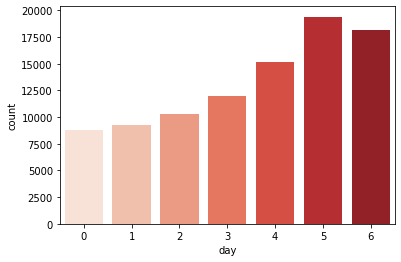

In [8]:
sns.countplot(x = 'day', data = logins, palette = 'Reds')

__Observation #1:__ There are upstick login counts during the end of the week (Friday to Sunday) as maybe more people are off work and have time to login. 

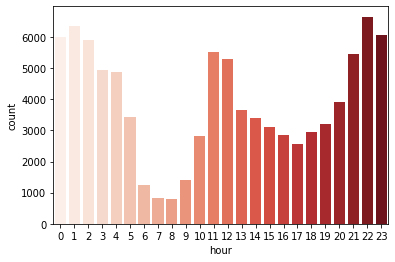

In [9]:
sns.countplot(x = 'hour', data = logins, palette = 'Reds')

__Observation #2:__ There are upstick login counts during the early hours of the night (12am - 4am), late hours (21 - 23pm), and lunch time (11am - 12pm) perhaps indicating that people login when they have time off work.

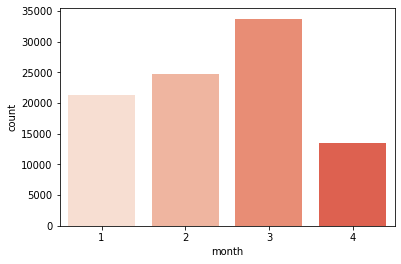

In [10]:
sns.countplot(x = 'month', data = logins)

__Observation #3:__ There are more logins in February and March compared to other months.

# 2 Experimental Design

1. What    would     you     choose     as     the     key    measure    of     success    of     this    experiment     in  encouraging    driver     partners     to     serve    both     cities,    and    why    would     you     choose     this    metric?

For this analysis, the key metric would be the number of trips taken across both cities after the two-way toll was reduced. So for example, we would count the number of trips from Gotham ---> Metropolis from driver partners who primarily drive in Gotham and the number of trips from Metropolis ---> Gotham from driver partners who primarily drive in Metropolis.

2.Describe    a    practical     experiment     you    would    design     to     compare     the    effectiveness    of     the  proposed     change     in     relation     to     the     key    measure    of     success.    Please    provide    details     on: 

<b> 2a. how     you    will     implement     the    experiment </b>

The number of trips taken across two cities will be counted before and after the two way toll was reduced. We will focus on trip from Gotham --> Metropolis and Metropolis --- > Gotham. For this experiment, we will exclude drivers who make regular trips across the two cities before the toll was reduced because it is expected that those driving partners will continue to make those trips. If there is a statistically significant increase in the number of trips from driving partners (excluding drivers that made regular trips) then we can conclude that the toll reduction had effect.

<b> 2b. what     statistical     test(s)     you    will     conduct     to     verify     the     significance    of     the  observation </b>


We will perform a 2 way ANOVA to test whether there is stasticially significant difference. Furthermore, a post-hoc test will determine there is stistically significance test between say Metropolis --> Gothan before and after the toll levy.

<b> 2c. how     you    would     interpret     the     results    and    provide     recommendations     to     the     city  operations     team    along    with    any     caveats. </b>

This statistically analysis will be able to tell us: </br>
* whether toll made an impact: if there are statistically significant difference between number of trips before and after the toll </br>
* difference across cities: if mean number of trips from Metropolis to Gotham after toll was statistically higher than mean number of trips from Gotham to Metropolis
* If test is successful, city operations team should continue to reduce the toll.
* If there are differences across cities after the experiment was conducted that were not observed before the experiment was conducted there needs to be additional analysis as to why this has occured. For example, were partner drivers from Gotham to Metropolis less likely to know that the toll was reduced? Does the agency need to spend more advertising dollars communicating the program?

However, we should note that as this is quasi-experimental approach so it doesn't really take take into account additional factors that might explain the results. For example:
* factors like time of day i.e. easier for Metropolis to Gotham partners who work mostly during day in the weekday to pick up extra few shift during night than Gotham to Metropolis drivers who work during the night hard and they are very tired to during the day.

# 3. Predictive Modeling

In [11]:
ult = pd.read_json('ultimate_data_challenge.json',orient = 'columns')


In [12]:
ult.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


## 3.0 Feature Engineering

In [13]:
#difference between sign up date and the date of their last trip
ult['date_diff'] = pd.to_datetime(ult['last_trip_date']).dt.date - pd.to_datetime(ult['signup_date']).dt.date

In [14]:
#if they took trip in last 30 days
ult['outcome'] = ult.trips_in_first_30_days.apply(lambda x: 1 if x > 0 else 0)

In [15]:
#last month
ult['last_month'] = pd.to_datetime(ult.last_trip_date).dt.month

In [16]:
# day of week for the last trip taken
ult['last_dow'] = pd.to_datetime(ult.last_trip_date).dt.dayofweek

In [17]:
#day of week for the sign up date
ult['signup_dow'] = pd.to_datetime(ult.signup_date).dt.dayofweek

In [18]:
# week of the month
ult['last_wom'] = ((pd.to_datetime(ult.last_trip_date).dt.day - 1)/7).round(0)

In [19]:
ult[['outcome']].groupby('outcome').size()/ult.shape[0]

outcome
0    0.3078
1    0.6922
dtype: float64

__Note:__ the data set is somewhat unbalanced as only 30% of people took a trip in last 30 days.

In [ ]:
#find for how many months the users have been active
ult['month_diff'] = (ult['date_diff']/np.timedelta64(1, 'M')).round(0).astype(int)
#then create binary variable for users that have only been active for 6 month
ult['six_month_active'] = ult['month_diff'].apply(lambda x: 1 if x == 6 else 0)
#dataset is severly unbalanced only 9% of users last for 6 months.
ult[['six_month_active']].groupby('six_month_active').size()/ult.shape[0]

# 3.1 Exploratory Analysis

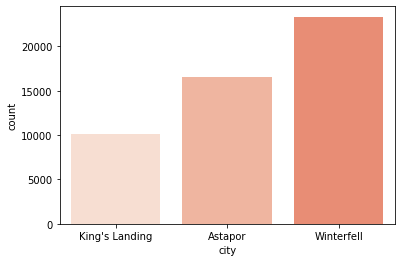

In [20]:
sns.countplot(x = 'city', data = ult)

__Observation #1:__ Most of the users signed up in Winterfell and then Astapor city.

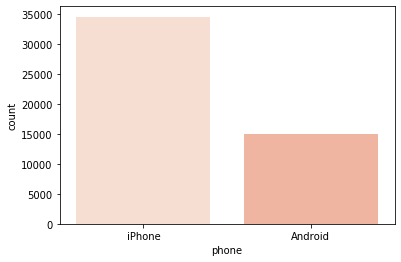

In [21]:
sns.countplot(x = 'phone', data = ult)

__Observation #2:__ Most of users have iphone.

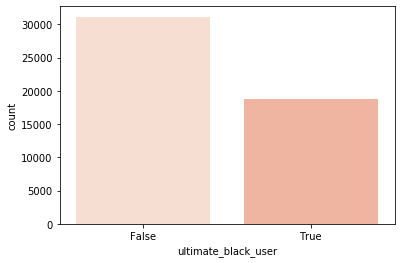

In [22]:
sns.countplot(x = 'ultimate_black_user', data = ult)

__Observation #3:__ Most of users didn't order Ultimate Black in their first 30 days

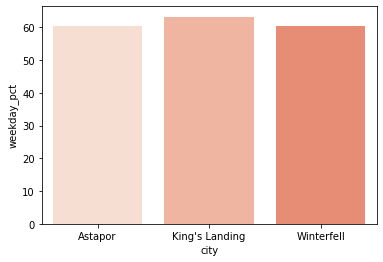

In [23]:
sns.barplot(x = 'city', y = 'weekday_pct' , 
            data = ult[['city',
                        'weekday_pct']].groupby('city').agg({'weekday_pct': 'mean'}).reset_index())

__Observation #4:__ It seems like King's Landing has slightly higher percentage of trips that occur during the weekend.

# 3.2 Predictive Analytics

In [24]:
ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,date_diff,outcome,last_month,last_dow,signup_dow,last_wom
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143 days,1,6,1,5,2.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96 days,0,5,0,2,1.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1 days,1,1,1,0,1.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170 days,1,6,6,4,4.0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47 days,1,3,5,0,2.0


In [30]:
ult.isnull().sum()/ult.shape[0]

city                      0.00000
trips_in_first_30_days    0.00000
signup_date               0.00000
avg_rating_of_driver      0.16244
avg_surge                 0.00000
last_trip_date            0.00000
phone                     0.00792
surge_pct                 0.00000
ultimate_black_user       0.00000
weekday_pct               0.00000
avg_dist                  0.00000
avg_rating_by_driver      0.00402
date_diff                 0.00000
outcome                   0.00000
last_month                0.00000
last_dow                  0.00000
signup_dow                0.00000
last_wom                  0.00000
month_diff                0.00000
six_month_active          0.00000
dtype: float64

__Note:__ variables avg_rating_of_driver, phone, and avg_rating_by_driver have missing values. For the purpose of this analysis avg_rating_of_driver and avg_rating_by driver will be inputted. Missing values for phone will be replaced with unknown as only small % of values are missing.

## 3.3 Impute and downsample

### 3.3a Imputation

In [35]:
X = ult.drop(['six_month_active','month_diff','date_diff'],axis = 1)
y = ult.six_month_active

In [37]:
#select floats
X_float = X.select_dtypes('float')
#imput
imp = IterativeImputer(max_iter=10, verbose=0)
imp.fit(X_float)
X_imp_float = imp.transform(X_float)
X_imp_float = pd.DataFrame(X_imp_float, columns= X_float.columns)

In [38]:
#concatenated the imputed variables with the rest of the data
X = pd.concat([X.select_dtypes(exclude = 'float'),X_imp_float],axis = 1)

In [39]:
#replace na in phone with unknown
X.phone = X.phone.fillna('unknown')

In [41]:
X.shape

(50000, 17)

### 3.3b DownSample

In [45]:
#undersample
undersample = RandomUnderSampler(sampling_strategy='majority')

In [46]:
X_over, y_over = undersample.fit_resample(X, y)

In [47]:
y_over.groupby(y_over).size()

six_month_active
0    3518
1    3518
Name: six_month_active, dtype: int64

## 3.3c Train/Test Split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42) #test_train model


## 3.4 Modeling

Based on this analysis, we have created a binary model where 1 is if users is retained in 6 month and 0 is they were not retained. Given how imbalanced the dataset was, you needed to undersample it to ensure balance between the classes. In addition, as there were several missing values imputing was performed. For the purpose of this challenge, we are using several classification models (Xgboost,Random Forest, SVC, Logistic Regression) and sklearn pipeline we were able to to evaluate all these models to see which one gives optimal performance.

In [49]:
from sklearn.base import BaseEstimator

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [50]:

categorical_features = ['city','ultimate_black_user','phone','outcome','last_month','last_dow','signup_dow','last_wom']
categorical_transformer = Pipeline(steps=[
   ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [51]:
numeric_features = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','weekday_pct','avg_dist','avg_rating_by_driver']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
         ('num', numeric_transformer,numeric_features)])

In [53]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', DummyEstimator())])

In [54]:

search_space = [ #input 8 classifiers 
                    
                 {
                  'clf': [xgb.XGBClassifier()]},
                {'clf': [linear_model.SGDClassifier(max_iter=1000, tol=1e-3)]},
                {
                 'clf': [RandomForestClassifier(max_depth=5,random_state=0)]
                } ,
                {
                 'clf': [SVC(max_iter = 1000)]},
    

    
                {
                  'clf':[AdaBoostClassifier()]},
            
                {
                    'clf': [LogisticRegression()]},

                                

]

In [55]:
grid = GridSearchCV(pipe, cv=5, param_grid=search_space,error_score = 0,verbose = 10, n_jobs = -1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   23.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.7s finished


GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['city',
                                                                          'ultimate_black_user',
                                                                          'phone',
                                                                          'outcome',
                                                                          'last_month',
                                                                          'last_dow',
                                                                          's

In [56]:
print("Best: %f using %s" % (grid.best_score_, 
    grid.best_params_))

Best: 0.906599 using {'clf': LogisticRegression()}


In [57]:
pipe.set_params(**grid.best_params_)
pipe.fit(X_train,y_train)
y_preds = pipe.predict(X_test)

In [58]:
print('Accuracy score on test set %.3f' % accuracy_score(y_test, y_preds))

Accuracy score on test set 0.913


## 3.5 Classification Report

In [59]:

print(confusion_matrix(y_test, y_preds, labels=range(2)))
print(classification_report(y_test, y_preds))

[[ 895  181]
 [   3 1032]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1076
           1       0.85      1.00      0.92      1035

    accuracy                           0.91      2111
   macro avg       0.92      0.91      0.91      2111
weighted avg       0.93      0.91      0.91      2111



The output of the classification report shows that the model precision and recall is low indicating that there are values that they are more likely to misclassify. However, the overall accuracy is great (91%) indicating that the model is fairly strong.

## 3.6 Feature Influence

In [76]:
dooh_col_names = preprocessor.transformers_[0][1]['onehot'].get_feature_names(categorical_features).tolist()

In [78]:
num_cols = X.select_dtypes('float').columns.tolist()

In [79]:
col_f = num_cols[:-1] + dooh_col_names

In [80]:
import eli5

In [81]:
eli5.show_weights(pipe[1],top = 50, feature_names = col_f)

Weight?,Feature
+6.957,last_month_1
+3.665,outcome_1
+3.351,signup_dow_5
+2.046,signup_dow_4
+1.205,last_month_3
+0.900,last_dow_3
+0.424,city_King's Landing
+0.400,last_month_4
+0.207,surge_pct
+0.072,avg_rating_of_driver


Based on the model results and feature importance, the team can use this data to create variety of different tests. For example, if higher retention is associated people from King's landing then they can offer additional incentives (discounts to those people). Most of the highly important variables are associated with dates (i.e. people who used service in January (last_month_1) or people who signuped on Friday (signup_dow)) so any additional incentives around time of day usage can bring additional areas of exploration.